# 1. Introduction
The purpose of this notebook is to assess the profit opportunity of quantile trading strategy based on factors prediction.

Though traditional financial ratios offer valuable insights into a company's financial health, they may not always provide the most timely or comprehensive perspective for quantile trading. A factor-based approach, with its focus on predictive analytics and a broader set of variables, can offer a more dynamic and potentially more profitable strategy for navigating the complexities of the US equity market. Therefore, in this notebook, we will try to construct a dynamic quantile trading strategy based on factor and equity return prediction.

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from seaborn import heatmap
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

from src import *

# 2. Data

We mainly obtain price and financial data from Quandl database (EOD and Zacks). The preprocess of data contains 3 major parts:
1. Universe selection
2. Ratio calculation
3. Return calculation

We then perform exploratory data analysis (EDA) on ratios and factor returns to guide our prediction model construction.

In [20]:
tickers = find_valid_universe()
print(f"Our universe contains {len(tickers)} tickers in total.")

Our universe contains 396 tickers in total.


In [ ]:
ratio = calc_ratio(use_cache=True, use_data_cache=True, tickers=tickers
                   ).dropna(how="all", axis=1)
ratio_col = list(set(ratio_col).intersection(ratio.columns))
ratio.shape

In [29]:
print(f"Ratio list (n={len(ratio_col)}): {ratio_col}")

Ratio list (n=68): ['excl_exp', 'curr_ratio', 'cash_profit', 'oper_cash_flow_per_share', 'ret_invst', 'V20', 'ebit_margin', 'rev_growth', 'AU', 'ret_6_12', 'VEMA12', 'price_pos', 'AD', 'quantile_95', 'PVO', 'cmo', 'rs_volatility', 'p_volatility', 'Altman_Z_Score', 'DPO', 'rcv_turn', 'win_pct', 'alpha6', 'pretax_profit_margin', 'book_val_per_share', 'asset_turn', 'z_score', 'AR', 'BIASVOL', 'bias', 'day_sale_rcv', 'FI', 'free_cash_flow_per_share', 'skew', 'TURN10', 'ret_1_6', 'volume_shock', 'yz_volatility', 'rd_bias', 'macd', 'tot_debt_tot_equity', 'ret_0_1', 'ret_autocorr', 'free_cash_flow', 'kurt_skew', 'NPR', 'profit_margin', 'pe', 'illiquidity', 'HMA', 'ret_asset', 'gross_margin', 'fluc', 'invty_turn', 'ulcer', 'VSTD20', 'RPPS', 'BR', 'ret_equity', 'K20', 'ERBU', 'lterm_debt_cap', 'ERBE', 'asset_growth', 'DC', 'ret_tang_equity', 'oper_profit_margin', 'alpha12']


In [30]:
factor = calc_factor(use_cache=False, ratio=ratio)
factor.shape

(290, 68)

In [2]:
df_ff = get_ff_data()
df_ff.shape
price = pd.read_pickle("data/prices.pkl")["adj_close"].unstack("ticker")

price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

In [29]:
price.index #= price.index.to_pydatetime()

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-08', '2000-01-09', '2000-01-10',
               '2000-01-11', '2000-01-12',
               ...
               '2024-02-18', '2024-02-19', '2024-02-20', '2024-02-21',
               '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25',
               '2024-02-26', '2024-02-27'],
              dtype='datetime64[ns]', length=8822, freq='D')

# 3. Factor Selection

In [3]:
ratio = pd.read_pickle('ratio_68.pkl')
ratio.head()

curr_ratio  free_cash_flow_per_share  ret_equity  \
date       ticker                                                     
2000-01-31 A              NaN                       NaN         NaN   
           AAPL           NaN                       NaN         NaN   
           ABT            NaN                       NaN         NaN   
           ADBE           NaN                       NaN         NaN   
           ADI            NaN                       NaN         NaN   

                   gross_margin  ret_asset  tot_debt_tot_equity  \
date       ticker                                                 
2000-01-31 A                NaN        NaN                  NaN   
           AAPL             NaN        NaN                  NaN   
           ABT              NaN        NaN                  NaN   
           ADBE             NaN        NaN                  NaN   
           ADI              NaN        NaN                  NaN   

                   oper_profit_margin  invty_turn  ret_invst  \
date       ticker                                              
2000-01-31 A                      NaN         NaN        NaN   
           AAPL                   NaN         NaN        NaN   
           ABT                    NaN         NaN        NaN   
           ADBE                   NaN         NaN        NaN   
           ADI                    NaN         NaN        NaN   

                   pretax_profit_margin  ...  ret_0_1  ret_1_6  ret_6_12  \
date       ticker                        ...                               
2000-01-31 A                        NaN  ...      NaN      NaN       NaN   
           AAPL                     NaN  ...      NaN      NaN       NaN   
           ABT                      NaN  ...      NaN      NaN       NaN   
           ADBE                     NaN  ...      NaN      NaN       NaN   
           ADI                      NaN  ...      NaN      NaN       NaN   

                   skew  volume_shock  rs_volatility  p_volatility  \
date       ticker                                                    
2000-01-31 A        NaN      0.604983       0.023066      0.021375   
           AAPL     NaN      0.897883       0.036539      0.033523   
           ABT      NaN      1.008005       0.008837      0.007463   
           ADBE     NaN      1.323902       0.018877      0.020044   
           ADI      NaN      1.168522       0.022570      0.021200   

                   yz_volatility  ret_autocorr  forward_ret  
date       ticker                                            
2000-01-31 A            0.005118           NaN     0.413974  
           AAPL         0.019121           NaN     0.072657  
           ABT          0.003300           NaN     0.038796  
           ADBE         0.003686           NaN     0.536808  
           ADI          0.002023           NaN     0.454377  

[5 rows x 69 columns]

In [4]:
ratio.index.levels[0]

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29'],
              dtype='datetime64[ns]', name='date', length=290, freq='M')

In [4]:
factor = pd.read_pickle('factor_68.pkl')
factor.head()

,curr_ratio,free_cash_flow_per_share,ret_equity,gross_margin,ret_asset,tot_debt_tot_equity,oper_profit_margin,invty_turn,ret_invst,pretax_profit_margin,...,alpha12,ret_0_1,ret_1_6,ret_6_12,skew,volume_shock,rs_volatility,p_volatility,yz_volatility,ret_autocorr
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.020895,NaN,NaN,NaN,NaN,0.013664,0.197074,0.212161,0.138495,NaN
2000-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.002184,0.020683,NaN,NaN,NaN,-0.019608,0.003956,-0.003264,0.009069,-0.045571
2000-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.077491,-0.030886,NaN,NaN,NaN,-0.024911,-0.171923,-0.177224,-0.160017,0.005379
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.036874,-0.088195,NaN,NaN,NaN,-0.020919,-0.073495,-0.092978,-0.073725,-0.012357
2000-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.025464,0.031177,NaN,NaN,NaN,0.024682,0.099050,0.095943,0.103528,-0.076145


In [27]:
factor.index

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29'],
              dtype='datetime64[ns]', name='date', length=290, freq='M')

# 3.1. Information Coefficient

In [5]:
### calculate IC ###
ratio.sort_index(level=['date'],ascending=True,inplace=True)
total_date = list(ratio.index.get_level_values('date').unique())
ic_spearman = pd.DataFrame(columns=total_date)
def spearman_corr(x,ic_spearman):
    date = x.index[0][0]
    sp_corr = []
    for i in factor.columns:
        clean = x[[i,'forward_ret']].dropna()
        sp_stats = stats.spearmanr(clean[i],clean['forward_ret'])
        if sp_stats[1]<0.1: #check p-value
            sp_corr.append(sp_stats[0])
        else:
            sp_corr.append(0)
    ic_spearman[date] = sp_corr

ratio.groupby(level=['date']).apply(spearman_corr,ic_spearman)
ic_spearman.index = factor.columns

In [6]:
### rank by IC ###
ic_spearman_rank = abs(ic_spearman.copy())
for i in ic_spearman_rank.columns:
    ic_spearman_rank[i] = ic_spearman_rank[i].rank()
r1 = ic_spearman_rank.copy()

# ### rank by predicted factor return ###
# r1 = predicted_factor_ret.T.copy()
# for i in r1.columns:
#     r1[i] = r1[i].rank()

### take average of the two rank ###   
# r = (r2 + r2)/2
# r = r.dropna(how="all", axis=1)
# r.head(5)

In [7]:
### choose the factor for each month ###
factor_chosen_ic = {}
for date in r1.loc[:, "2007-05-31":].columns:
    factor_chosen_ic[date] = r1[date].nlargest(10).index.tolist()

In [8]:
factor_chosen_df = pd.DataFrame(factor_chosen_ic)
factor_chosen_df

,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
0,BR,rev_growth,fluc,BR,ret_0_1,illiquidity,ret_1_6,price_pos,ret_6_12,BR,...,p_volatility,p_volatility,BR,macd,ulcer,macd,rs_volatility,ulcer,price_pos,ret_0_1
1,AR,rd_bias,yz_volatility,rev_growth,price_pos,rs_volatility,BR,ret_0_1,lterm_debt_cap,gross_margin,...,rs_volatility,rs_volatility,cmo,ret_0_1,p_volatility,p_volatility,p_volatility,ret_1_6,cmo,DPO
2,DPO,price_pos,p_volatility,ret_1_6,macd,p_volatility,fluc,DPO,RPPS,AR,...,quantile_95,V20,AR,V20,rs_volatility,rs_volatility,ulcer,fluc,DPO,macd
3,lterm_debt_cap,ret_equity,rs_volatility,win_pct,ret_6_12,ulcer,win_pct,ret_1_6,ret_autocorr,ERBE,...,V20,quantile_95,illiquidity,AR,V20,ERBU,V20,free_cash_flow,ret_0_1,cmo
4,tot_debt_tot_equity,invty_turn,V20,cmo,DPO,quantile_95,V20,rev_growth,Altman_Z_Score,Altman_Z_Score,...,yz_volatility,ulcer,win_pct,cmo,ret_0_1,V20,fluc,V20,illiquidity,price_pos
5,ret_0_1,z_score,FI,asset_turn,cmo,yz_volatility,yz_volatility,cmo,rcv_turn,book_val_per_share,...,asset_turn,yz_volatility,free_cash_flow_per_share,win_pct,macd,ret_6_12,yz_volatility,illiquidity,ERBU,win_pct
6,curr_ratio,ret_asset,quantile_95,ebit_margin,BR,fluc,quantile_95,win_pct,day_sale_rcv,skew,...,ret_0_1,ret_autocorr,free_cash_flow,fluc,quantile_95,yz_volatility,quantile_95,p_volatility,macd,illiquidity
7,price_pos,ret_invst,asset_growth,oper_profit_margin,fluc,V20,rs_volatility,macd,AR,profit_margin,...,z_score,illiquidity,AD,p_volatility,fluc,FI,curr_ratio,ret_6_12,ret_1_6,ERBU
8,FI,pretax_profit_margin,price_pos,profit_margin,quantile_95,BR,cmo,FI,macd,ebit_margin,...,alpha12,ret_1_6,DC,rs_volatility,yz_volatility,pe,BR,quantile_95,win_pct,fluc
9,NPR,profit_margin,ret_1_6,asset_growth,alpha12,price_pos,p_volatility,asset_turn,AD,cmo,...,BR,BR,DPO,BR,curr_ratio,Altman_Z_Score,ret_1_6,rs_volatility,DC,HMA


In [16]:
factor_chosen_df.to_pickle('factor_chosen_ic.pkl')

# 3.2. ICIR

In [9]:
def icir_cal(n):
    icir = pd.DataFrame(columns=ic_spearman.index, index=ic_spearman.columns)

    ### ICIR_n calculation ###
    for i in icir.columns:
        mean_rolling = ic_spearman.T[i].rolling(n, min_periods=1).mean()
        std_rolling = ic_spearman.T[i].rolling(n, min_periods=1).std()
        icir[i] = mean_rolling/std_rolling
    icir = icir.T

    return icir


def icir_rank(n): #n: length of the rolling window
    icir = icir_cal(n)

    ### rank by ICIR ###
    rank_icir = abs(icir.copy())
    for i in rank_icir.columns:
        rank_icir[i] = rank_icir[i].rank()
    rk = rank_icir.copy()

    ### choose the factor for each month ###
    factor_chosen_icir = {}
    for date in rk.loc[:, "2007-05-31":].columns:
        factor_chosen_icir[date] = rk[date].nlargest(10).index.tolist()
    
    return rk, factor_chosen_icir


In [10]:
r_6, factor_chosen_icir_6 = icir_rank(6)
r_12, factor_chosen_icir_12 = icir_rank(12)
r_18, factor_chosen_icir_18 = icir_rank(18)
r_24, factor_chosen_icir_24 = icir_rank(24)

# 3.3 ICIR as the weight of the IC

In [11]:
ic_spearman

,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
curr_ratio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.148280,0.000000,0.000000,-0.111762,-0.201652,0.115379,0.337673,0.000000,0.137947,0.127943
free_cash_flow_per_share,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.190998,0.146386,0.000000,0.088492,0.000000,0.227381,0.168031,0.195444
ret_equity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.097421,0.000000,0.000000,0.112742,0.000000,0.104199,0.000000,0.000000
gross_margin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.174278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.088388,0.000000
ret_asset,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125564,0.140756,0.140934,0.000000,-0.127805,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
volume_shock,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122707,...,-0.176387,0.000000,0.000000,0.000000,0.000000,0.000000,-0.144549,0.000000,0.000000,-0.171090
rs_volatility,0.366032,0.000000,-0.417158,-0.184131,0.230458,0.000000,0.157368,-0.243815,-0.333482,-0.424979,...,0.296674,0.281433,0.000000,-0.221906,-0.299558,0.282830,0.467335,-0.252533,0.000000,0.000000
p_volatility,0.367766,0.000000,-0.431495,-0.207336,0.247748,0.000000,0.162373,-0.240850,-0.340747,-0.419902,...,0.309267,0.298090,0.000000,-0.222480,-0.302601,0.285103,0.458360,-0.261576,0.000000,0.000000
yz_volatility,0.267160,0.000000,-0.429061,-0.193554,0.260276,0.000000,0.000000,-0.212068,-0.281435,-0.430913,...,0.266944,0.217216,0.000000,-0.151038,-0.210797,0.242189,0.397184,-0.147602,0.000000,0.000000


In [12]:
def weighted_ic_rank(n): #n: length of the rolling window
    icir = icir_cal(n)
    weighted_ic = icir * ic_spearman

    ### rank by weighted ic ###
    rank_weighted_ic = abs(weighted_ic.copy())
    for i in rank_weighted_ic.columns:
        rank_weighted_ic[i] = rank_weighted_ic[i].rank()
    rk = rank_weighted_ic.copy()

    ### choose the factor for each month ###
    factor_chosen_weighted_ic = {}
    for date in rk.loc[:, "2007-05-31":].columns:
        factor_chosen_weighted_ic[date] = rk[date].nlargest(10).index.tolist()
    
    return rk, factor_chosen_weighted_ic

In [13]:
r_w_6, factor_chosen_weighted_ic_6 = weighted_ic_rank(6)
r_w_12, factor_chosen_weighted_ic_12 = weighted_ic_rank(12)
r_w_18, factor_chosen_weighted_ic_18 = weighted_ic_rank(18)
r_w_24, factor_chosen_weighted_ic_24 = weighted_ic_rank(24)

In [14]:
from typing import Callable
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def get_least_corr(df: pd.DataFrame, n: int = 5) -> dict[datetime, list[str]]:
    # Compute the correlation matrix and take the absolute value
    corr_matrix = df.corr().abs()
    
    # Initialize the list of selected columns with the column having the lowest average correlation
    selected_columns = [corr_matrix.mean().idxmin()]
    remaining_columns = list(set(df.columns) - set(selected_columns))
    
    # Iteratively add columns with the lowest average correlation to the selected columns
    while len(selected_columns) < n:
        avg_corr = corr_matrix[selected_columns].mean(axis=1).drop(selected_columns)
        next_column = avg_corr.idxmin()
        selected_columns.append(next_column)
        remaining_columns.remove(next_column)
    
    return selected_columns

def get_least_vif(df: pd.DataFrame, 
                  n: int = 5, 
                  vif_trh: int = 10) -> dict[datetime, list[str]]:
    
    def calculate_max_vif(col):
        nonlocal df
        df_with_const = add_constant(df[col].dropna(how="any"))
        if len(df_with_const) == 0:
            return np.inf
        vif = pd.Series(
            [variance_inflation_factor(df_with_const.values, i) 
             for i in range(df_with_const.shape[1])],
            index=df_with_const.columns
        )
        return vif.max()

    selected_columns = get_least_corr(df, n=1)
    remaining_columns = df.columns.tolist()
    
    while len(selected_columns) < n and len(remaining_columns) > 0:
        vif_values = {}
        for column in remaining_columns:
            test_columns = selected_columns + [column]
            max_vif = calculate_max_vif(test_columns)
            vif_values[column] = max_vif
        
        min_vif_column = min(vif_values, key=vif_values.get)
        if vif_values[min_vif_column] < vif_trh:  # Assuming a VIF threshold of 10
            selected_columns.append(min_vif_column)
            remaining_columns.remove(min_vif_column)
        else:
            break  # Stop if adding any of the remaining columns results in high VIF
    
    return selected_columns

def iter_dates(
        func: Callable, 
        df: pd.DataFrame, 
        min_period: int = 12
) -> dict[datetime, list[str]]:
    results = {}
    df = df.sort_index()
    
    for i in range(min_period, len(df)):
        # factor dataframe index was lagged by 1 period
        eval_date = df.index[i] + pd.offsets.MonthEnd(1)
        print(eval_date)
        results[eval_date] = func(df.iloc[:i])
    return results

In [ ]:
# vif_factors = iter_dates(get_least_vif, factor)
# vif_factors

In [ ]:
# corr_factors = iter_dates(get_least_corr, factor)
# corr_factors

# 4. Trade

## 4.1. Single-Stock Ranking

In [15]:
from sklearn.preprocessing import scale

def single_stock_pred_ols(
        ratio: pd.DataFrame, 
        factor_chosen: dict[datetime, list[str]],
        min_ticker: int = 50,
) -> pd.DataFrame:
    """
    Prediction next period single stock return
    
    Parameters
    ----------
    ratio: pd.DataFrame
        Index: (date, ticker)
        column: ratios + forward return
    factor_chosen: dict[datetime, list[str]]
        date -> list of factor selected for the period
    min_ticker: int
        minimum number of ticker predicted to generate prediction,
        If too many ticker has missing on any of the selected factor 
        on certain date, we will not predict, i.e. change position on this date.
        
    Returns
    -------
    pd.DataFrame:
        Index: (date, ticker)
        Columns: "predicted_ret"
    """
    pred = {}
    for train_date, selected in factor_chosen.items():
        test_date = train_date + pd.offsets.MonthEnd(1)
        if any([x not in ratio.index.get_level_values("date").unique() 
                for x in [train_date, test_date]]):
            print(f"Not trained on {train_date}: No ratio data on train/test date")
            continue
        train_df = ratio.loc[train_date][
            selected + ["forward_ret"]].dropna(how="any")
        if len(train_df) < min_ticker:
            print(f"Not trained on {train_date}: Too many tickers have missing")
            continue
        X_train = scale(train_df[selected])
        y_train = train_df["forward_ret"]
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        test_df = ratio.loc[test_date][selected].dropna(how="any")
        pred[test_date] = pd.Series(
            model.predict(scale(test_df)),
            index = test_df.index
        )
    return pd.DataFrame(pred).unstack().dropna().rename("predicted_ret").to_frame()

## 4.2. Backtest

In [18]:
def backtest_pipe(
    name: str,
    factor_chosen: dict[datetime, list[str]],
    ratio: pd.DataFrame = ratio,
    pred_func: Callable = single_stock_pred_ols, 
) -> pd.Series:
    """
    Combine single stock prediction, backtest position calculation, and 
    backtest PnL tracking in the same function for easy use.
    
    Parameters
    ----------
    name: str
        Describe how factor are selected
    factor_chosen: dict[datetime, list[str]]
        a dictionary of factor selected
    ratio: pd.DataFrame
        Index: (date, ticker)
        column: ratios + forward return
    pred_func: Callable
        single stock prediction function, default = OLS.

    Returns
    -------
    pd.Series: 
        backtest cumulative return results evaluation, e.g. sharpe...
        
    This function also draw plot of cumulative with given name.
    """
    # Equity return prediction
    predicted_returns = pred_func(
        ratio=ratio, factor_chosen=factor_chosen)
    predicted_returns.to_pickle('data/predicted_return_icir12.pkl')
    
    
    # Trading backtest
    INIT_CAPITAL = 2e7
    position = calc_position_by_rank(
        df_price=price, 
        df_ratio=predicted_returns.unstack("ticker"),
        rank_formula="-predicted_ret",
        lb=0,
        ub=0.1,
        interval=None,
        use_change=False,
        position_size=INIT_CAPITAL / 20
    )
    trade_cls = CalcTrade(
        df_price=price,
        init_cap=INIT_CAPITAL
    )
    summary_df = trade_cls.iter_dates(position=position)
    summary_df["total_ret"].rename(name).plot(figsize=(12,4), title="Entire Period Return")

    return pd.Series({
        **eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12),
        **ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)
    }, name=name)

Not trained on 2024-02-29 00:00:00: No ratio data on train/test date


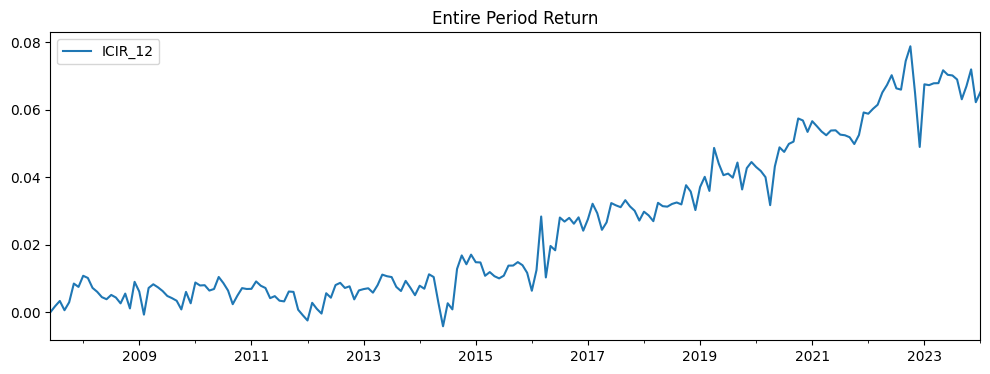

In [19]:
results1 = {}
for (name, factor_chosen) in [
    # ("IC", factor_chosen_ic),
    # ("ICIR_6", factor_chosen_icir_6),
    ("ICIR_12", factor_chosen_icir_12),
    # ("ICIR_18", factor_chosen_icir_18),
    # ("ICIR_24", factor_chosen_icir_24),
]:
    results1[name] = backtest_pipe(name, factor_chosen)
plt.legend()

In [ ]:
results1

Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date
Not trained on 2024-02-29 00:00:00: No ratio data on train/test date


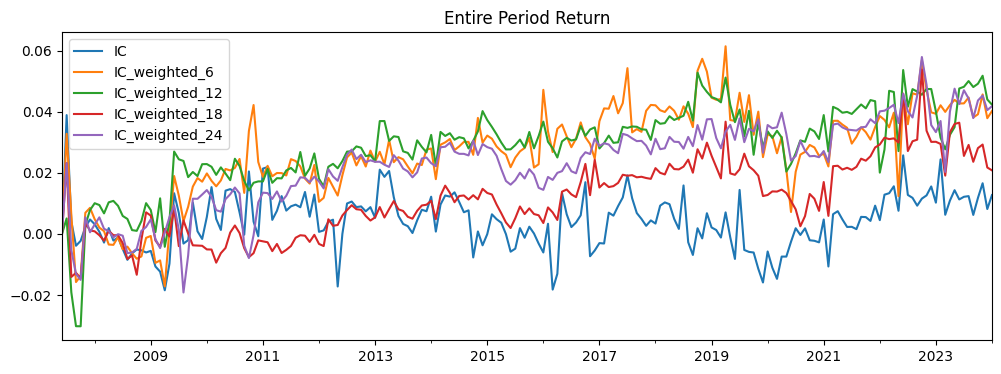

In [56]:
results2 = {}
for (name, factor_chosen) in [
    ("IC", factor_chosen_ic),
    ("IC_weighted_6", factor_chosen_weighted_ic_6),
    ("IC_weighted_12", factor_chosen_weighted_ic_12),
    ("IC_weighted_18", factor_chosen_weighted_ic_18),
    ("IC_weighted_24", factor_chosen_weighted_ic_24),
]:
    results2[name] = backtest_pipe(name, factor_chosen)
plt.legend()

In [57]:
results2

{'IC': return            0.012721
 mean              0.000043
 std               0.009341
 skew              0.244451
 kurtosis          3.598085
 sharpe           -0.110767
 sharpe_mkt       -0.006983
 sortino          -0.154567
 var              -0.056915
 cvar             -0.077453
 max_drawdown     -0.136159
 downside_beta    -0.074935
 alpha             0.040690
 beta_Mkt-RF      -0.123441
 beta_SMB          0.217620
 beta_HML         -0.103124
 beta_RF          48.920064
 Name: IC, dtype: float64,
 'IC_weighted_6': return            0.040227
 mean              0.000055
 std               0.008646
 skew              0.258469
 kurtosis          3.588404
 sharpe           -0.114870
 sharpe_mkt       -0.006598
 sortino          -0.158766
 var              -0.047354
 cvar             -0.072496
 max_drawdown     -0.090309
 downside_beta    -0.013393
 alpha             0.292407
 beta_Mkt-RF      -0.175105
 beta_SMB          0.123897
 beta_HML         -0.884549
 beta_RF          90.68918